In [10]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [50]:
import pandas as pd
from pandas_datareader import data, DataReader
from datetime import datetime

gs = DataReader('GS',  'yahoo', datetime(2009, 1, 1), datetime(2019, 1, 1))
gs.reset_index(level=0, inplace=True)
gs.head(3)
gs[['Date', 'Adj Close']].rename(index=str, columns={'Adj Close': 'GS'}).to_csv('data/panel_data_close.csv',
                                                                       date_format='%Y-%m-%d', index=False)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2009-01-02,87.620003,82.190002,84.019997,86.760002,14088500.0,76.137115
1,2009-01-05,90.949997,85.459999,85.809998,88.779999,15996700.0,77.909775
2,2009-01-06,92.199997,87.720001,90.050003,88.709999,21551800.0,77.848366


In [51]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d')
dataset_ex_df = pd.read_csv('data/panel_data_close.csv', header=0, parse_dates=[0], date_parser=parser)
dataset_ex_df[['Date', 'GS']].head(3)

,Date,GS
0,2009-01-02,76.137115
1,2009-01-05,77.909775
2,2009-01-06,77.848366


In [52]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2516 number of days in the dataset.


<Figure size 1400x500 with 0 Axes>

Text(0.5,0,'Date')

Text(0,0.5,'USD')

Text(0.5,1,'Figure 2: Goldman Sachs stock price')

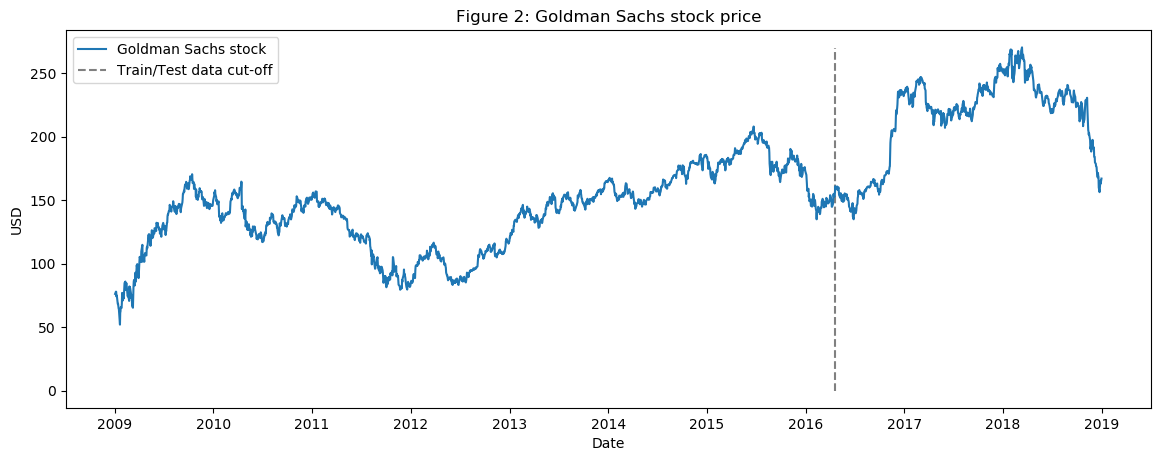

In [55]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['GS'], label='Goldman Sachs stock')
plt.vlines(datetime(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [56]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1761. Number of test days: 755.


## 3.2 Technical Indicator

In [107]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.DataFrame.ewm(dataset['price'], span=26).mean()
    dataset['12ema'] = pd.DataFrame.ewm(dataset['price'], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moment.rolling_std(dataset['price'],20)
    dataset['20sd'] = dataset['price'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

In [108]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['GS']].rename(index=str, columns={'GS': 'price'}))
dataset_TI_df.head(14)

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,76.137115,NaN,NaN,76.137115,76.137115,0.000000,NaN,NaN,NaN,76.137115,75.137115
1,77.909775,NaN,NaN,77.057535,77.097306,0.039771,NaN,NaN,NaN,77.466610,76.909775
2,77.848366,NaN,NaN,77.341673,77.390445,0.048772,NaN,NaN,NaN,77.730902,76.848366
3,74.153854,NaN,NaN,76.450498,76.368780,-0.081718,NaN,NaN,NaN,75.316395,73.153854
4,74.952431,NaN,NaN,76.103090,75.983963,-0.119127,NaN,NaN,NaN,75.072749,73.952431
5,73.644844,NaN,NaN,75.610723,75.415434,-0.195289,NaN,NaN,NaN,74.119505,72.644844
6,68.160118,74.686643,NaN,74.285671,73.796436,-0.489236,NaN,NaN,NaN,70.144763,67.160118
7,68.379486,73.578411,NaN,73.334039,72.666002,-0.668037,NaN,NaN,NaN,68.967732,67.379486
8,66.422531,71.937376,NaN,72.309602,71.430821,-0.878781,NaN,NaN,NaN,67.270845,65.422531
9,64.790260,70.071932,NaN,71.272006,70.172437,-1.099568,NaN,NaN,NaN,65.617094,63.790260


In [113]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

In [ ]:
plot_technical_indicators(dataset_TI_df, 400)